# Predicting geodesic calculations from model activations

This notebook investigates whether it is possible to predict geographic information and components of geodesic computations from the parameters and activations of neural nets, both trained on geographic tasks, and pretrained LLMs.

Tasks:
- [X] Train a transformer on the distances between cities. Test whether its embeddings or activations predict city coordinates or trig functions of coordinates.
- [ ] Train a transformer on distances between cities, when the city names have been tokenized as they would for a language model.
- [ ] Test which pre-trained language models are good at generating coordinates or distances from few-shot prompting.
- [ ] Try linear probes for coordinates or distances for pre-trained models.
- [ ] Test whether the issue is that the model forgets the location of the city, or cannot perform the computation. I.e. from the coordinates we predict for a city from the linear probe, does the model's estimation of the distance correspond to the true distance (if those incorrect coordinates are used instead).


TODO: Prettify the graphs, they're huge atm

In [8]:
DATASET = 'data/1000'
OUTPUT_DIR = 'outputs'

## How does an E2E transformer predicting the distance between cities work?

We can use the great circle distance to calculate the distance between two points on a sphere. This calculation assumes that the earth is a perfect sphere, rather than an oblate spheroid, so is an approximation. However, it approximates distances far better than language models so, so seems like an adequate starting point.

![Great circle distance formula](images/great%20circle.png)

In [ ]:
# TODO: The current model doesn't perform very well, should use a more performant model.
import os

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split 
import matplotlib.pyplot as plt
from IPython.display import clear_output

from dataset import CityDistanceDataset
from model import Transformer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

distance_dataset = CityDistanceDataset(DATASET)

train_count = int(len(distance_dataset) * 0.8)
val_count = len(distance_dataset) - train_count
train_dataset, val_dataset = random_split(distance_dataset, [train_count, val_count])

EPOCHS = 500
BATCH_SIZE = 2**10
LR = 1e-4

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = Transformer(
    d_model=32,
    nhead=2,
    d_hid=128,
    nlayers=1,
    ntoken=distance_dataset.city_count,
    regressor=True,
).to(device)

MODEL_PATH = os.path.join(OUTPUT_DIR, 'coordinate_model.pickle')
print(MODEL_PATH)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH))
    print("Loaded model parameters from existing model at", MODEL_PATH)
else:
    loss_fn = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=LR)

    val_losses = []

    for epoch in range(EPOCHS):
        model.train()
        for x, y in train_dataloader:
            x = torch.stack([x[0], x[1]], dim=1).to(device)
            y = y.to(torch.float32).to(device)
            y_pred = model(x).squeeze(1)
            loss = loss_fn(y_pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        val_loss = 0
        for x, y in val_dataloader:
            x = torch.stack([x[0], x[1]], dim=1).to(device)
            y = y.to(torch.float32).to(device)
            y_pred = model(x).squeeze(1)
            val_loss += loss_fn(y_pred, y).item()
        val_loss /= len(val_dataloader)

        val_losses.append(val_loss)
        clear_output(wait=True)

        # Plot the validation loss
        plt.plot(val_losses)
        plt.title('Validation Loss')
        plt.xlabel('Epoch')
        plt.xlim([0, EPOCHS])
        plt.ylabel('Loss')
        plt.show()

        torch.save(model.state_dict(), MODEL_PATH)

outputs/coordinate_model.pickle
Loaded model parameters from existing model at outputs/coordinate_model.pickle


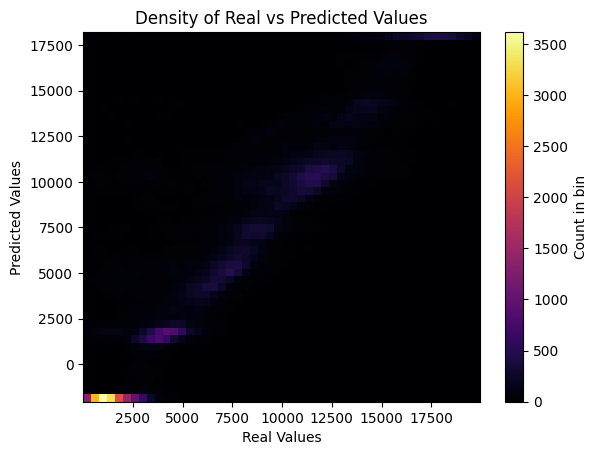

Closest match: 13461.544 13461.455


In [10]:
model.eval()
reversed_predictions = []
true = []
for x, y in val_dataloader:
    x = torch.stack([x[0], x[1]], dim=1).to(device)
    y = y.to(torch.float32).to(device)
    y_pred = model(x).squeeze(1)
    reversed_predictions.append(y_pred)
    true.append(y)

reversed_predictions = torch.cat(reversed_predictions).cpu().detach().numpy()
true = torch.cat(true).cpu().detach().numpy()

plt.hist2d(true, reversed_predictions, bins=50, cmap='inferno')
plt.colorbar(label='Count in bin')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Density of Real vs Predicted Values')
plt.show()

nearest_match = (abs(true - reversed_predictions)).argmin()
print("Closest match:", true[nearest_match], reversed_predictions[nearest_match])

### Embeddings are linear maps of coordinates
A transformer that is trained on city-token to distance learns as its embeddings a linear map of the true coordinates of the cities.

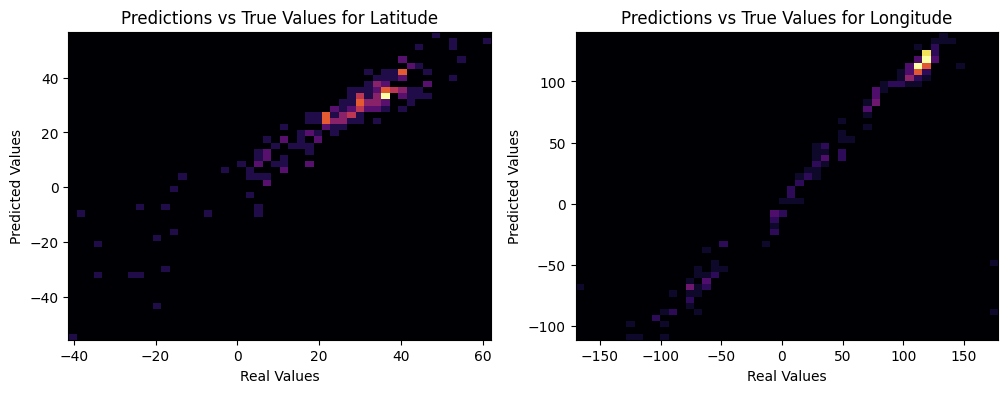

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

from dataset import CoordinateDataset

coordinate_dataset = CoordinateDataset(DATASET)

embeddings = None
for param in model.embedding.parameters():
    embeddings = param.detach().cpu().numpy()
    break

sine_coords = [d[1] for d in coordinate_dataset]

X_train, X_test, y_train, y_test = train_test_split(embeddings, sine_coords, test_size=0.2, random_state=42)
embedding_coordinate_linear_regressor = Ridge()
embedding_coordinate_linear_regressor.fit(X_train, y_train)

y_pred = embedding_coordinate_linear_regressor.predict(X_test)

y_test = np.array(y_test)
y_pred = np.array(y_pred)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
coordinate_columns = ['Latitude', 'Longitude']

for i, ax in enumerate(axs.flatten()):
    ax.hist2d(y_test[:, i], y_pred[:, i], bins=50, cmap='inferno')
    ax.set_xlabel('Real Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(f'Predictions vs True Values for {coordinate_columns[i]}')

### Trig functions of coordinates are only approximately linear for latitude
Calculating the distance between two coordinates requires applying trigonometric functions to the coordinates. As shown in the graphs below, whilst the computation of sin(lattiude) is almost linear due to the limited distribution of city at very high and very low latitudes, this is not the case for calculating the longitude.

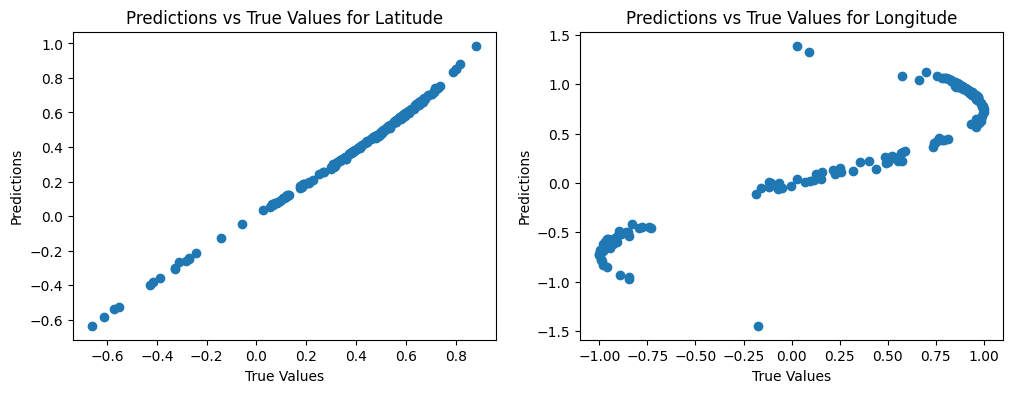

In [20]:
import math

coordinate_dataset = CoordinateDataset(DATASET)
coords = [d[1] for d in coordinate_dataset]

for col in ['Latitude', 'Longitude']:
    coordinate_dataset.df[col] = coordinate_dataset.df[col].apply(lambda x: math.sin(math.radians(x)))
sine_coords = [d[1] for d in coordinate_dataset]

X_train, X_test, y_train, y_test = train_test_split(coords, sine_coords, test_size=0.2, random_state=42)
linear_regressor = Ridge()
linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

y_test = np.array(y_test)
y_pred = np.array(y_pred)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
coordinate_columns = ['Latitude', 'Longitude']

for i, ax in enumerate(axs.flatten()):
    ax.scatter(y_test[:, i], y_pred[:, i])
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predictions')
    ax.set_title(f'Predictions vs True Values for {coordinate_columns[i]}')

Rather than computing the sine of the longitude and latitude at run time, the model also stores these values in the embeddings for each city.

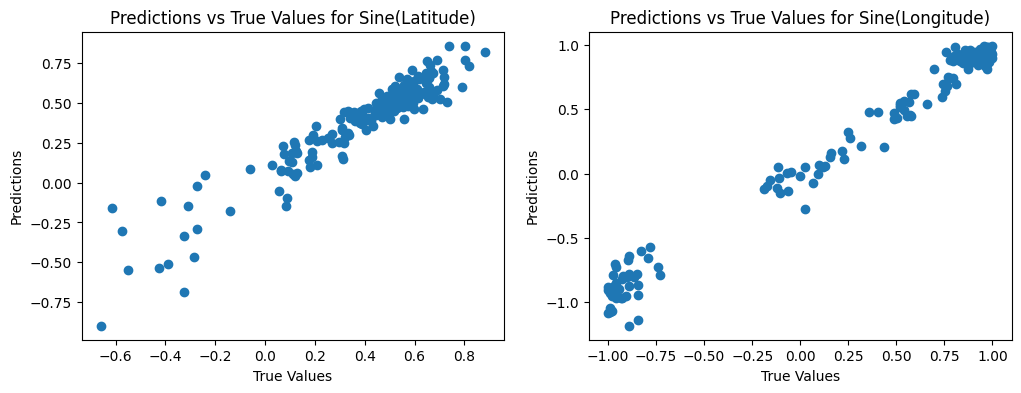

In [138]:
import math

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

from dataset import CoordinateDataset

coordinate_dataset = CoordinateDataset(DATASET)

for col in ['Latitude', 'Longitude']:
    coordinate_dataset.df[col] = coordinate_dataset.df[col].apply(lambda x: math.sin(math.radians(x)))

embeddings = None
for param in model.embedding.parameters():
    embeddings = param.detach().cpu().numpy()
    break

sine_coords = [d[1] for d in coordinate_dataset]

X_train, X_test, y_train, y_test = train_test_split(embeddings, sine_coords, test_size=0.2, random_state=42)
linear_regressor = Ridge()
linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

y_test = np.array(y_test)
y_pred = np.array(y_pred)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
coordinate_columns = ['Sine(Latitude)', 'Sine(Longitude)']

for i, ax in enumerate(axs.flatten()):
    ax.scatter(y_test[:, i], y_pred[:, i])
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predictions')
    ax.set_title(f'Predictions vs True Values for {coordinate_columns[i]}')

These sine values are essential to the model calculating the distance between the cities. We can see this by inverting the linear model to predict embeddings from the coordinates, remembering that the linear model is unable to predict the sine values from the coodinates. Here we see that the distances are distorted by a trigonometric function.

  0%|          | 0/771 [00:00<?, ?it/s]

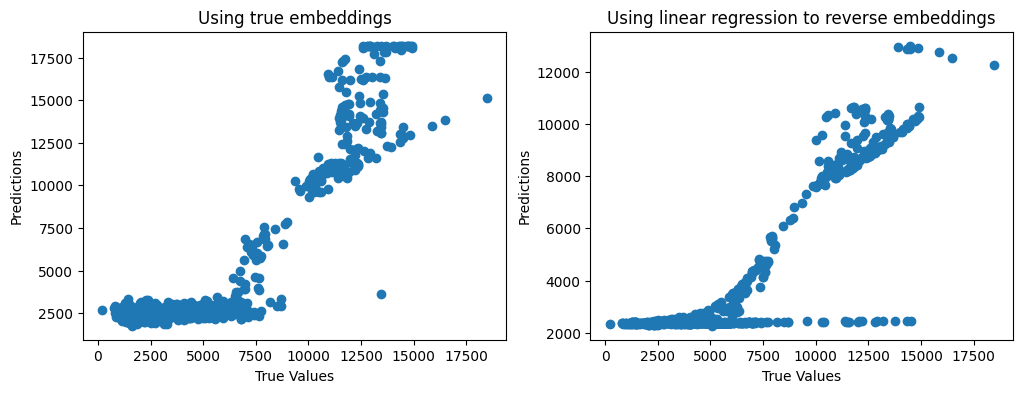

In [22]:
import numpy as np 
from tqdm.notebook import tqdm

coordinate_dataset = CoordinateDataset(DATASET)

distance_example = val_dataset[nearest_match]

examples = []
for i in range(len(distance_dataset)):
    if distance_dataset[i][0][0] == distance_example[0][0]:
        examples.append(distance_dataset[i])

true = [e[1] for e in examples]
predicted = model(torch.tensor([e[0] for e in examples]).to(device)).squeeze(1).cpu().detach().numpy()

embeddings = next(model.embedding.parameters())

model.eval()
reversed_predictions = []
with torch.no_grad():
    intercept = np.array(embedding_coordinate_linear_regressor.intercept_)
    coef = np.linalg.pinv(np.array(embedding_coordinate_linear_regressor.coef_))
    for e in tqdm(examples):
        city_coordinates = np.array(coordinate_dataset[e[0][1]][1])
        result = (city_coordinates - intercept) @ coef.T
        embeddings[distance_example[0][1]] = torch.tensor(result).to(device)
        input = torch.tensor([distance_example[0]]).to(device)

        predicted_distance = model(input).squeeze(1).cpu().detach().numpy()[0]
        reversed_predictions.append(predicted_distance)


fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axs.flatten()):
    if i == 0:
        ax.scatter(true, predicted)
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predictions')
        ax.set_title(f'Using true embeddings')
    else:
        ax.scatter(true, reversed_predictions)
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predictions')
        ax.set_title('Using linear regression to reverse embeddings')

## Tokenizing the city names
When the city names are tokenized, the model probably won't be able to store this information in the embedding. This is more similar to the case of pretrained transformers trying to perform this kind of computation.

In [23]:
import pandas as pd 

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

df = pd.read_csv('raw_data/all_cities.csv')
cities = df['city'].tolist()
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
tokenizer.train_from_iterator(cities, trainer=trainer)

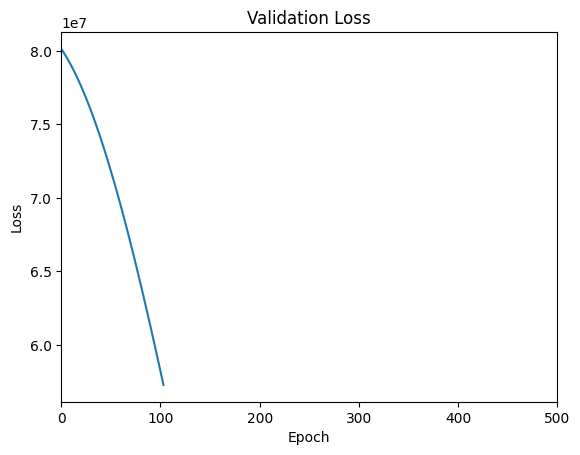

In [26]:
# TODO: Commonise this training code with the previous transformer
import os

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split 
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from IPython.display import clear_output

from dataset import CityDistanceDataset
from model import Transformer
import pandas as pd
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

distance_dataset = CityDistanceDataset(DATASET, return_strings=True)


train_count = int(len(distance_dataset) * 0.8)
val_count = len(distance_dataset) - train_count
train_dataset, val_dataset = random_split(distance_dataset, [train_count, val_count])

EPOCHS = 500
BATCH_SIZE = 2**10
LR = 1e-4

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = Transformer(
    d_model=32,
    nhead=2,
    d_hid=128,
    nlayers=1,
    ntoken=tokenizer.get_vocab_size(),
    regressor=True,
).to(device)

MODEL_PATH = os.path.join(OUTPUT_DIR, 'tokenised_coordinate_model.pickle')
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH))
    print("Loaded model parameters from existing model at", MODEL_PATH)
# else:
    loss_fn = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=LR)

    val_losses = []

    for epoch in range(EPOCHS):
        model.train()
        for x, y in train_dataloader:
            output = tokenizer.encode_batch(x)
            input_ids = [torch.tensor(enc.ids) for enc in output]
            attention_mask = [torch.tensor(enc.attention_mask) for enc in output]
            input_ids = pad_sequence(input_ids, batch_first=True).to(device)
            attention_mask = pad_sequence(attention_mask, batch_first=True).to(device)

            y = y.to(torch.float32).to(device)
            y_pred = model(input_ids, attention_mask).squeeze(1)
            loss = loss_fn(y_pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        val_loss = 0
        for x, y in val_dataloader:
            output = tokenizer.encode_batch(x)
            input_ids = [torch.tensor(enc.ids) for enc in output]
            attention_mask = [torch.tensor(enc.attention_mask) for enc in output]
            input_ids = pad_sequence(input_ids, batch_first=True).to(device)
            attention_mask = pad_sequence(attention_mask, batch_first=True).to(device)

            y = y.to(torch.float32).to(device)
            y_pred = model(input_ids, attention_mask).squeeze(1)
            loss = loss_fn(y_pred, y)
            val_loss += loss_fn(y_pred, y).item()
        val_loss /= len(val_dataloader)

        val_losses.append(val_loss)
        clear_output(wait=True)

        # Plot the validation loss
        plt.plot(val_losses)
        plt.title('Validation Loss')
        plt.xlabel('Epoch')
        plt.xlim([0, EPOCHS])
        plt.ylabel('Loss')
        plt.show()

        torch.save(model.state_dict(), MODEL_PATH)

## Predicting coordinates from city names in Pythia

The Pythia models struggle to produce city coordinates when prompted with a few-shot example. For each size of model, far better performance is achieved by training a linear model on the output embeddings. This is true even when the prompt contains no reference to coordinates, i.e. consists of only the city name.

In [ ]:
# TODO: Evaluate 12b too, but for some reason the kernel keeps crashing on it
model_sizes = ['70m', '160m', '410m', '1b','2.8b', '6.7b', '12b']

device = 'cpu'

In [ ]:
from transformers import GPTNeoXForCausalLM, AutoTokenizer
from IPython.display import clear_output

def get_model(model_size):
  model = GPTNeoXForCausalLM.from_pretrained(
    f"EleutherAI/pythia-{model_size}-deduped",
  ).to(device)
  tokenizer = AutoTokenizer.from_pretrained(
    f"EleutherAI/pythia-{model_size}-deduped",
  )
  return model, tokenizer

def generate_for_all(prompt, limit=20):
  predictions = []
  for model_size in model_sizes:
    model, tokenizer = get_model(model_size)
    inputs = tokenizer(prompt, return_tensors='pt').to(device)
    outputs = model.generate(**inputs, max_length=70, num_return_sequences=1)
    prediction = tokenizer.decode(outputs[0])
    without_prompt = prediction[len(prompt):]
    predictions.append(without_prompt[:limit])
  return predictions

def evaluate_model(inputs, targets):
    X_train, X_test, y_train, y_test = train_test_split(inputs.detach().cpu().numpy(), targets, test_size=0.2, random_state=42)
    reg = Ridge()
    reg.fit(X_train, y_train)

    y_pred = reg.predict(X_test)
    return np.mean((y_pred - y_test) ** 2), y_test, y_pred

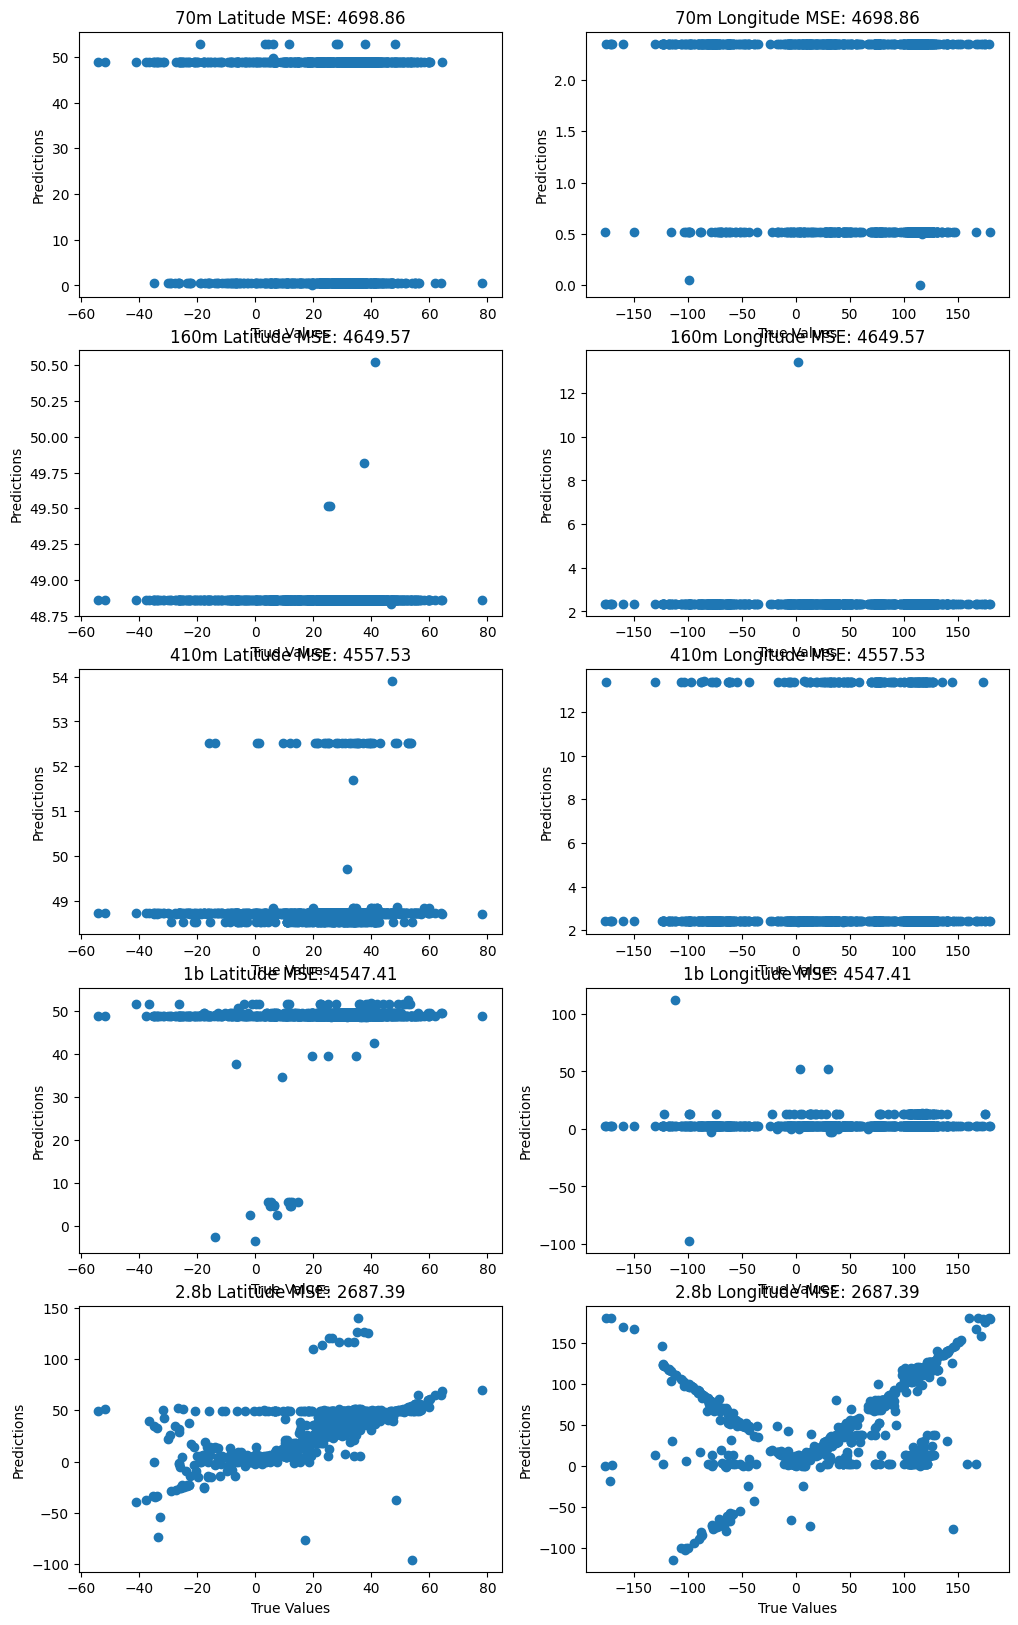

In [ ]:
import os
import pickle 
import re

import torch
from IPython.display import clear_output
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

from dataset import CoordinateDataset

coordinate_dataset = CoordinateDataset(DATASET)
cities = coordinate_dataset.df['City']
coordinates = coordinate_dataset.df[['Latitude', 'Longitude']]

def get_prompt(city_name):
  return f'The coordinates of Berlin are 52.5200° N, 13.4050° E. The coordinates of Paris are 48.8566° N, 2.3522° E. The coordinates of {city_name} are'

reversed_predictions = []
for model_size in model_sizes:
  predictions_path = os.path.join(OUTPUT_DIR, 'coordinates', f'pythia-{model_size}-generations.pickle')
  if os.path.exists(predictions_path):
      with open(predictions_path, 'rb') as f:
          model_predictions = pickle.load(f)
  else:
    model, tokenizer = get_model(model_size)
    model_predictions = []
    for city in tqdm(cities):
      prompt = get_prompt(city)
      inputs = tokenizer(prompt, return_tensors='pt').to(device)
      outputs = model.generate(**inputs, max_length=70, num_return_sequences=1)
      prediction = tokenizer.decode(outputs[0])
      model_predictions.append(prediction)

    with open(predictions_path, 'wb') as f:
      pickle.dump(model_predictions, f)

  clear_output(wait=True)
  reversed_predictions.append(model_predictions)

predicted_coordinates = []
for model_size, model_predictions in zip(model_sizes, reversed_predictions):
  model_coordinates = []
  for city, prediction in zip(cities, model_predictions):
    prediction = prediction[len(get_prompt(city)):]
    prediction = prediction.split('.', 3)[:3]
    coordinate_string = '.'.join(prediction)
    c = [float(s) for s in re.findall(r"[-+]?\d*\.\d+|\d+", coordinate_string)]
    model_coordinates.append(c[:2])
  predicted_coordinates.append(model_coordinates)

fig, axs = plt.subplots(len(model_sizes), 2, figsize=(12, 4*len(model_sizes)))
coordinate_columns = ['Latitude', 'Longitude']

for i, ax in enumerate(axs.flatten()):
    y_test = np.array(coordinates)
    y_pred = np.array(predicted_coordinates[i // 2])
    ax.scatter(y_test[:, i % 2], y_pred[:, i % 2])
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predictions')
    ax.set_title(f'{model_sizes[i//2]} {coordinate_columns[i % 2]} MSE: {np.mean((y_pred - y_test) ** 2):.2f}')
plt.show()

In [ ]:
import pickle

def get_neox_activation(layer):
    def hook(module, input, output):
        module.activation = output[0].detach()
    return hook

def get_model_activations(model, tokenizer, inputs):
    hook = model.gpt_neox.layers[-1].register_forward_hook(get_neox_activation('encoder'))

    # TODO: Switch to batches for better performance.
    activations = []
    for inp in tqdm(inputs):
        inputs = tokenizer(inp, return_tensors="pt")
        tokens = model.generate(**inputs.to(device), max_length=1)
        output = tokenizer.decode(tokens[0])
        mean_output = model.gpt_neox.layers[-1].activation.mean( dim=1).squeeze(0)
        activations.append(mean_output)
    activations = torch.stack(activations)
    return activations


def get_model_predictions(experiment_name, inputs, targets):
    mean_squared_errors = []
    y_tests = []
    y_preds = []

    experiment_dir = os.path.join(OUTPUT_DIR, experiment_name)
    if not os.path.exists(experiment_dir):
        os.makedirs(experiment_dir)    

    for model_size in model_sizes:
        outs_path = os.path.join(experiment_dir, f'pythia-{model_size}-predictions.pickle')

        if os.path.exists(outs_path):
            with open(outs_path, 'rb') as f:
                mean_squared_error, y_test, y_pred = pickle.load(f)
            mean_squared_errors.append(mean_squared_error)
            y_tests.append(y_test)
            y_preds.append(y_pred)
            continue

        model, tokenizer = get_model(model_size)
        activations = get_model_activations(model, tokenizer, inputs)
        mean_squared_error, y_test, y_pred = evaluate_model(activations, targets)

        with open(outs_path, 'wb') as f:
            pickle.dump((mean_squared_error, y_test, y_pred), f)
        
        mean_squared_errors.append(mean_squared_error)
        y_tests.append(y_test)
        y_preds.append(y_pred)
        clear_output(wait=True)
    
    return mean_squared_errors, y_tests, y_preds

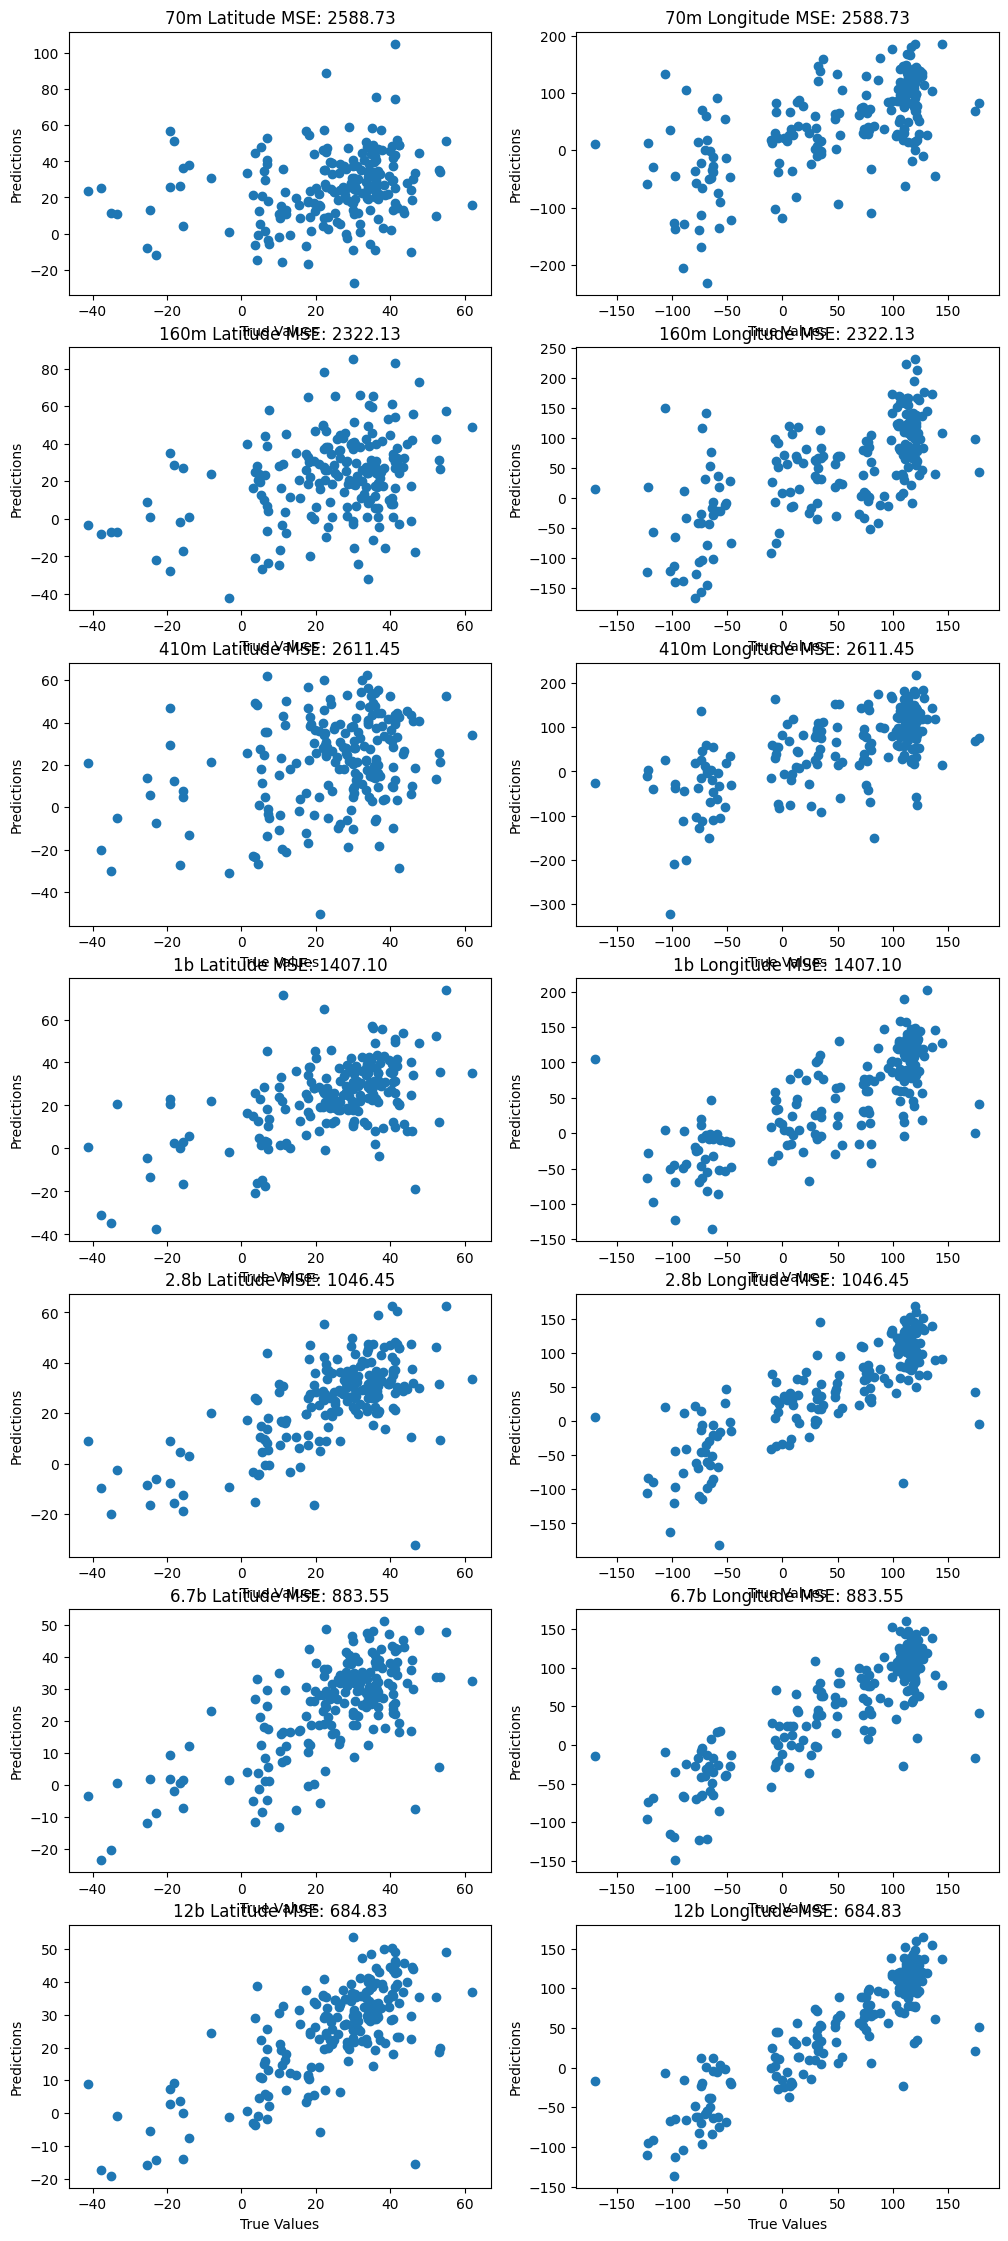

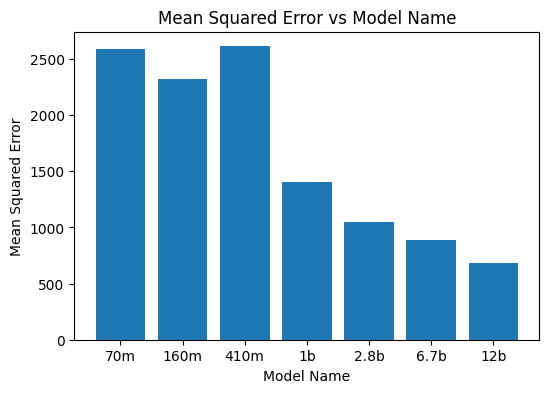

In [ ]:
coordinate_dataset = CoordinateDataset(DATASET)
cities = coordinate_dataset.df['City']
coordinates = coordinate_dataset.df[['Latitude', 'Longitude']]
mean_squared_errors, y_tests, y_preds = get_model_predictions('coordinates', cities, coordinates)
clear_output(wait=True)

fig, axs = plt.subplots(len(model_sizes), 2, figsize=(12, 4*len(model_sizes)))
coordinate_columns = ['Latitude', 'Longitude']

for i, ax in enumerate(axs.flatten()):
    y_test = np.array(y_tests[i // 2])
    y_pred = np.array(y_preds[i // 2])
    ax.scatter(y_test[:, i % 2], y_pred[:, i % 2])
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predictions')
    ax.set_title(f'{model_sizes[i//2]} {coordinate_columns[i % 2]} MSE: {mean_squared_errors[i // 2]:.2f}')
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(model_sizes, mean_squared_errors)
plt.xlabel('Model Name')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs Model Name')
plt.show()

## Predicting Distance from output embeddings

Similarly, we try to predict the distance between two cities from the output embeddings of the Pythia models with poor results. Whilst the larger Pythia models can generate some city coordinates, none of the Pythia models are able to generate the distance between city pairs.

TODO: Show that Pythia can't generate city pair distances

In [ ]:
from dataset import CityDistanceDataset

coordinate_dataset = CityDistanceDataset(DATASET)
sample_df = coordinate_dataset.df.sample(n=1000)
sample_df['Cities'] = 'The distance from ' + sample_df['City A'] + " to " + sample_df['City B'] + " is "
cities = sample_df['Cities']
distances = sample_df['Distance']
mean_squared_errors, y_tests, y_preds = get_model_predictions('distance', cities, distances)
clear_output(wait=True)

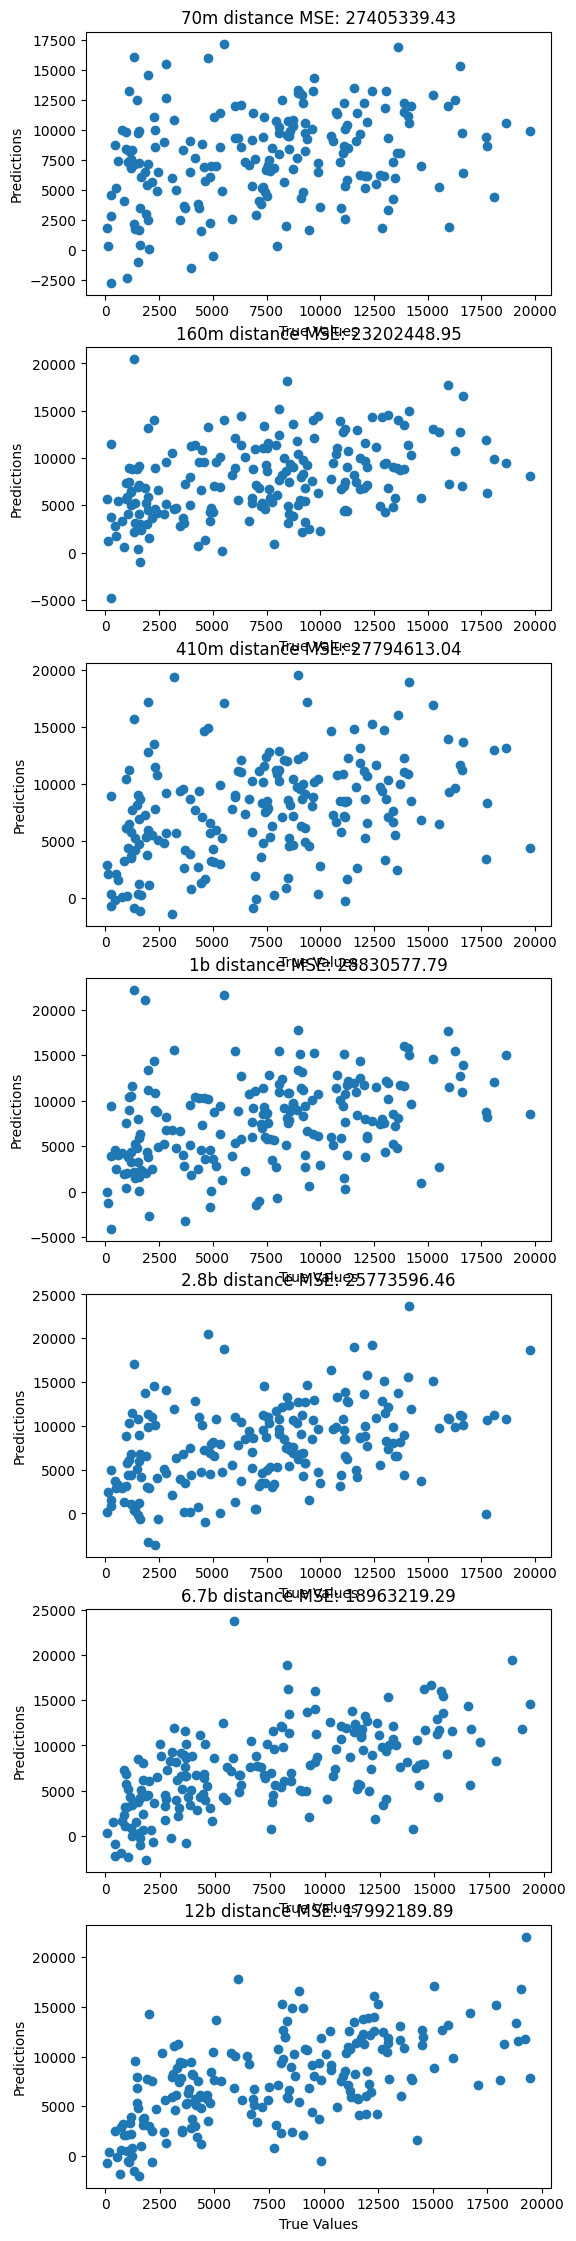

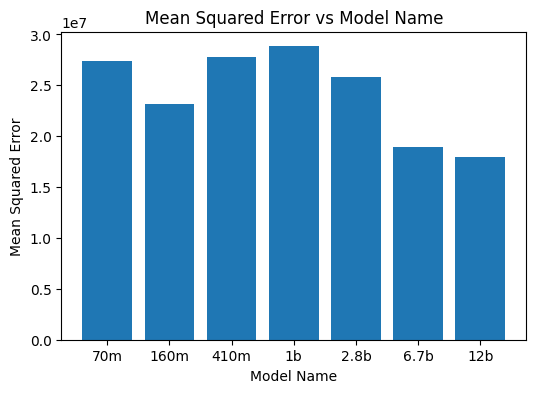

In [ ]:
fig, axs = plt.subplots(len(model_sizes), 1, figsize=(6, 4*len(model_sizes)))

for i, ax in enumerate(axs.flatten()):
    ax.scatter(y_tests[i], y_preds[i])
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predictions')
    ax.set_title(f'{model_sizes[i]} distance MSE: {mean_squared_errors[i]:.2f}')
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(model_sizes, mean_squared_errors)
plt.xlabel('Model Name')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs Model Name')
plt.show()